This is the kaggle version of a Pierre Auger Observatory Open Data notebook. You can run it by clicking on "Copy and Edit" in the top right corner.

In [ ]:
![ -d /kaggle/input/release-2021-v1/augeropendata ] && [ ! -d augeropendata ] && ln -s /kaggle/input/release-2021-v1/augeropendata augeropendata  # kaggle specific linking dataset to augeropendata directory

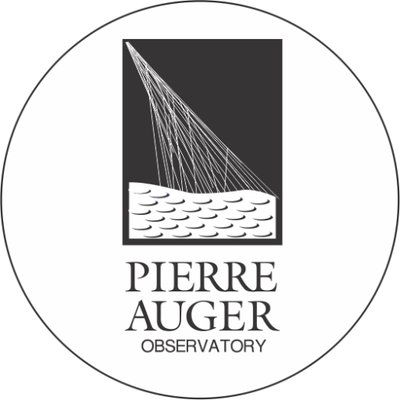
#  Analysis of $X_\mathrm{max}$ Measurements from the Fluorescence Detector of the Pierre Auger Observatory

<i>Notebook released together with the Pierre Auger Observatory Open Data release 2021 (<a href="https://doi.org/10.5281/zenodo.4487613">DOI 10.5281/zenodo.4487613</a>). More information at the <a href="https://www.auger.org/opendata/">Auger open data website</a>.</i>

$X_\mathrm{max}$ is the atmospheric depth at which the number of particles in an air shower reaches its maximum. It is the best measured shower observable that is correlated with the composition of the primary cosmic ray composition. $X_\mathrm{max}$ is directly measured with the fluorescence detectors of the Pierre Auger Observatory by observing the longitudinal development of the air shower.

 Lighter primaries penetrate deeper in the atmosphere than heavier primaries. This is because heavier primaries are to good approximation a superposition of many less energetic light primaries. Therefore, heavier elements dissipate their energy faster and do not have the energy to penetrate deeper in the atmosphere. 
 
 The aim of this analysis is to sample the $X_\mathrm{max}$ distribution and the corresponding first two moments to estimate the composition. This is achieved by comparing the observations with predictions from high energy hadronic interaction models.  This notebook will show the different steps towards the calculation of the first two  moments of the $X_\mathrm{max}$ distribution, the mean and standard deviation ($\langle X_\mathrm{max}\rangle$ and $\sigma(X_\mathrm{max})$).
 
NOTE: this is a **simplified version** of the $X_\mathrm{max}$ analysis applied to data from the Pierre Auger Observatory. The sampled $X_\mathrm{max}$ distributions are affected by the detector resolution and by the detector $X_\mathrm{max}$ acceptance. Both effects need to be estimated and corrected for a precise  estimation of the $X_\mathrm{max}$ moments. Here we will only show an approximate analysis for the mean shower maximum. Due to the fiducial event selection, this analysis agrees with the final one within a few g/cm$^2$. We also present the raw standard deviation of $X_\mathrm{max}$ without correction for the detector resolution and acceptance and show the resolution-corrected fluctuations. For how to proceed for a full analysis and correction for detector effects, please refer to [Phys. Rev. D 90, 122005 (2014)](https://inspirehep.net/literature/1317612). 

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import math
from scipy.optimize import curve_fit
import scipy.stats
from IPython.display import HTML
import numpy.polynomial.polynomial as poly
LegendFontSize=20
LabelFontSize= 20
TickFontSize= 15

In [ ]:
# Jupyter/ IPython formatting
from IPython.display import Math, Latex, display

In [ ]:
# Default values for plots
plt.rcParams["figure.figsize"] = [11, 6.94] # figure width and height
plt.rcParams["font.size"] = 20

In [ ]:
# Data loading, encapsulated to make it less installation and OS dependant
import os.path
from zipfile import ZipFile
def AugerOpen(fdir, file):
    """
    Loads a file from the auger open data release. Can be either in the local directory,
    in the parent directory or in the augeropendata directory.
    File is identified by it directory *fdir* and filename *file* and can be found in the directory
    or in a zip file.
    """
    for loc in [".", "..", "augeropendata", "data"]:
        fname = os.path.join(loc, fdir, file)
        if os.path.isfile(fname):
            return open(fname)
        zname=os.path.join(loc, fdir + ".zip")
        if os.path.isfile(zname):
            with ZipFile(zname) as myzip:
                return myzip.open(os.path.join(fdir, file))
    raise FileNotFoundError(os.path.join(fdir, file))

## Read the data file and select events for Xmax analysis 

In [ ]:
data = pd.read_csv(AugerOpen('summary', 'dataSummary.csv'))
data['lgE'] = np.log10(data['fd_totalEnergy']) + 18 # units: lg(E/eV)

Prepare a data frame with unique events, i.e., with each `id` present only once. This dataframe gets indexed by event `id` to allow merging with data like averages from multi-eye events.

The flag **'fd_hdXmaxEye'** is used to select the events that are suitable for the $X_\mathrm{max}$ analysis. The selected events have a range of geometries that allow to measure their $X_\mathrm{max}$ with good resolution (better than $40$ g/cm$^2$ for each event and better than $25$ g/cm$^2$ on average) over a certain $X_\mathrm{max}$ range. This $X_\mathrm{max}$ range has been chosen so that most of the observed $X_\mathrm{max}$ distribution (at each energy bin) is contained within this $X_\mathrm{max}$ range. This is called 'the fiducial field of view".  Such selection of geometries allow us to sample the $X_\mathrm{max}$ distributions almost free of
detector acceptance effects.

In principle, we can request a good $X_\mathrm{max}$ measurement over a large range of $X_\mathrm{max}$ values removing entirely the detector effects when sampling the $X_\mathrm{max}$ distributions. However, this will reduce dramatically the statistics. So, the selected fiducial $X_\mathrm{max}$ range is a compromise between reducing the detector effects in the sampled $X_\mathrm{max}$ distribution, while keeping a reasonably high statistics. Therefore, there are small residual detector effects in the tails of the $X_\mathrm{max}$ distribution, that we will correct using a parametrization of the estimated detector $X_\mathrm{max}$ acceptance.

In [ ]:
xmax_data = data[(data.fd_hdXmaxEye == 1)].copy() # copy so we can add columns later

grouped_xmax_data = xmax_data.groupby('id')
unique_xmax_data = xmax_data.drop_duplicates('id').set_index('id')

n_events = len(xmax_data)
n_unique = len(unique_xmax_data)

display(Latex(f'''Read {n_events} Xmax events of which {n_unique} are unique.
    The total number of FD events (counting multi-eye events as multiple events) is {n_events}.'''))

## Merge multi-eye events

At high energies, a cosmic shower can be viewed over large distances and therefore be detected by more than one FD station. In the next step we merge these so-called stereo, triple and quadruple events and calculate a unique energy and $X_\text{max}$ for each shower as the weighted average of all FD stations.

In [ ]:
## Calculate weights: w = 1/uncertainty^2
xmax_data['fd_e_weight'] = 1 / np.square(xmax_data.fd_dtotalEnergy)
xmax_data['fd_xmax_weight'] = 1 / np.square(xmax_data.fd_dxmax)
## Calculate value * w
xmax_data['fd_e_weighted'] = xmax_data.fd_totalEnergy * xmax_data.fd_e_weight
xmax_data['fd_xmax_weighted'] = xmax_data.fd_xmax * xmax_data.fd_xmax_weight

# average of energies
sum_of_e_weights = grouped_xmax_data['fd_e_weight'].sum()
fd_avg_e = grouped_xmax_data['fd_e_weighted'].sum() / sum_of_e_weights 
unique_xmax_data['fd_avg_lgE'] = np.log10(fd_avg_e*1e18)
fd_davg_e = 1 / np.sqrt(sum_of_e_weights)
fd_davg_lge = fd_davg_e / fd_avg_e / np.log(10.)
unique_xmax_data['fd_davg_lgE'] = fd_davg_lge

# average of Xmax
sum_of_xmax_weights = grouped_xmax_data['fd_xmax_weight'].sum()
fd_avg_xmax = grouped_xmax_data['fd_xmax_weighted'].sum() / sum_of_xmax_weights 
unique_xmax_data['fd_avg_xmax'] = fd_avg_xmax
fd_davg_xmax = 1 / np.sqrt(sum_of_xmax_weights)
unique_xmax_data['fd_davg_xmax'] = fd_davg_xmax

## Scatter plot of $X_\text{max}$ vs. energy

After this step, we can now plot the individual energies and shower maxima. Note that the error bars include only the statistical uncertainty of the measurement. The scattering of the data points is due to a combination of these uncertainties and shower-to-shower fluctuations. The latter are not accounted for in the error bars, but they are part of the physics observables used to study the composition of cosmic rays.

In [ ]:
fig = plt.figure()

x = unique_xmax_data['fd_avg_lgE']
y = unique_xmax_data['fd_avg_xmax'] 
xerr = unique_xmax_data['fd_davg_lgE']
yerr = unique_xmax_data['fd_davg_xmax']
plt.errorbar(x, y, xerr=xerr, yerr=yerr, label='both limits (default)', fmt='.',
             color= 'black', ecolor='gray', mfc='white', alpha=0.8)
plt.ylabel(r'$X_\mathrm{max}$/(g/cm$^{2}$)')
plt.xlabel(r'$\lg(E/\mathrm{eV})$')
plt.show()

## Defining the energy bins

 Below we define the energy bin ranges. We will use the same energy bin ranges as in [Phys. Rev. Lett. 104 (2010) 091101](https://inspirehep.net/literature/845300), i.e. a binning that was used in an early publication of $X_\text{max}$ with statistics comparable to this data release.

In [ ]:
lge_max = np.amax(unique_xmax_data['fd_avg_lgE'])
Ebins = [17.8, 17.9, 18.0, 18.1, 18.2, 18.3, 18.4, 18.5, 18.6, 18.7, 18.8, 18.9, 19.0, 19.2, 19.4, 
         (int(lge_max*10)+1)/10.]
display(Latex(f'The maximum energy in this data set is lg(E/eV) = {lge_max:7.2f}.'))

## Energy distribution of selected events ##

In [ ]:
plt.figure(num=None, dpi=70, facecolor='w', edgecolor='k')
plt.hist(unique_xmax_data['fd_avg_lgE'], bins=Ebins, color='black', histtype='step',
         linewidth=2, label=f"{len(unique_xmax_data['fd_avg_lgE'])} events")
plt.xlabel('lg(E/eV)', fontsize=LabelFontSize)
plt.xticks(fontsize=TickFontSize)
plt.yticks(fontsize=TickFontSize)
plt.legend(fontsize=LegendFontSize)
plt.yscale('log')
plt.show()

## The $X_\mathrm{max}$ distributions and the $X_\mathrm{max}$ moments
 

In [ ]:
# look into numpyification
def GetRawXmaxMoments(Ebins,lgEList,XmaxList):
    """
    Stores the list of Xmax values for each energy bin.
    Calculates the raw Xmax moments and their errors.
    Conveniently organize all the data in a Dictionary called 'Moments'.

    'Moments' is a dictionary that contains for each energy bin:
     
   * A list of Xmax values
   * Xmax moments and their errors (without correcting for the Xmax acceptance or resolution)
   * number of events
   * mean energy
   * systematic uncertainties
   
    """
    
    MeanXmaxList = []
    SigmaList = []
    MeanXmaxErrList = []
    SigmaErrList = []
    MeanLgEList = []
    NevtsList = []
    XmaxDistList = []
  
    
    for E1, E2 in zip(Ebins[:-1], Ebins[1:]): 
        ECut = (E1 <= lgEList) & (lgEList < E2)
        
        lgEmean = lgEList[ECut].mean() 
        Nevts = len(lgEList[ECut])

        XmaxMean = np.mean(XmaxList[ECut])
        SigmaXmax = np.std(XmaxList[ECut])
        MeanErr =  SigmaXmax / np.sqrt(Nevts)
        
        # uncertainty of the standard deviation
        # (Gaussian approximation, a more accurate estimate uses the fourth
        # central moment, see Particle Data Group)
        SigmaErr = SigmaXmax / np.sqrt(2*Nevts)
        
        MeanLgEList.append(lgEmean)
        NevtsList.append(Nevts)
        
        XmaxDistList.append(XmaxList[ECut])
        
        MeanXmaxList.append(XmaxMean)
        SigmaList.append(SigmaXmax)
        MeanXmaxErrList.append(MeanErr)
        SigmaErrList.append(SigmaErr)
        
    Moments = {'raw':{'mean': np.asanyarray(MeanXmaxList), 
                      'meanErr': np.asanyarray(MeanXmaxErrList),
                      'sigma': np.asanyarray(SigmaList),
                      'sigmaErr': np.asanyarray(SigmaErrList),
                      'Emean': np.asanyarray(MeanLgEList),
                      'Nevts': np.asanyarray(NevtsList)
                     },
               'distributions': XmaxDistList
              }
        
    return Moments

In [ ]:
Moments = GetRawXmaxMoments(Ebins,unique_xmax_data['fd_avg_lgE'],unique_xmax_data['fd_avg_xmax'])

## Plot the energy dependence of the average $X_\mathrm{max}$ also known as $\langle X_\mathrm{max} \rangle$

The mean of the shower maximum is proportional to the logarithm of the primary mass. The energy evolution of $X_\text{max}$ gives thus an estimate of the change of composition with energy.

In [ ]:
x = Moments['raw']['Emean'] 
y = Moments['raw']['mean'] 
yerr = Moments['raw']['meanErr']

plt.errorbar(x, y, yerr, linestyle='none', marker='o', color='black')
plt.ylabel(r'$\langle X_\mathrm{max}\rangle$/(g/cm$^{2}$)')
plt.xlabel(r'$\lg(E/\mathrm{eV})$')
plt.ylim(700, 820)
plt.show()

## Plot the 'raw' standard deviation of $X_\text{max}$ also known as  $\sigma_\mathrm{raw}(X_\text{max})$

In [ ]:
x = Moments['raw']['Emean'] 
y = Moments['raw']['sigma'] 
yerr = Moments['raw']['sigmaErr']

plt.errorbar(x, y, yerr, linestyle='none', marker='o', color='black')
plt.ylabel(r'$\sigma_\mathrm{raw}(X_\mathrm{max})$/(g/cm$^{2}$)')
plt.xlabel(r'$\lg(E/\mathrm{eV})$')
plt.ylim(0, 70)
plt.show()

In [ ]:
StringEnergyRange1 = r'${} \leq \mathrm{{lg}}(E/\mathrm{{eV}})$'
StringEnergyRange =  r'${} \leq \mathrm{{lg}}(E/\mathrm{{eV}}) < {}$'


def PlotXmaxdistributions(Moments,version,Ebins,mode):

    """ Plot the Xmax distribution for each energy bin """
    
    MeanLgEList = Moments[version]['Emean']
    XmaxDist = Moments['distributions']
    Nevts = Moments[version]['Nevts']
    XmaxMean = Moments[version]['mean']
    SigmaXmax = Moments[version]['sigma']
    
    BinSize = 20
    XmaxMin = 320.
    XmaxMax = 1400.
    Nbins = np.int((XmaxMax - XmaxMin)/BinSize)
    


    NEbins = len(Ebins) - 1
    Ncol = 4
    
    if (NEbins % Ncol):
        Nrows = 1 + int (NEbins/Ncol)
    else:
        Nrows = NEbins / Ncol 

    
    plt.figure(num=None, figsize=(18, Nrows*Ncol*0.6), dpi=80, facecolor='w', edgecolor='k')
    plt.subplots_adjust(hspace=0.1) 
    for i, E1 in enumerate(MeanLgEList):
        
        plt.subplot(Nrows, Ncol, i+1)
        HistWithCutsRecCorr = plt.hist(XmaxDist[i], density=False,
                                       range=[XmaxMin, XmaxMax], bins=Nbins,
                                       histtype='step', label='',
                                       color='black', linewidth=2)
        
        if (mode == 'open'):  #open limit for last energy bin
            if (i == len(MeanLgEList)-1):
                PlotTitle = StringEnergyRange1.format(Ebins[i])
            else:
                PlotTitle = StringEnergyRange.format(Ebins[i], Ebins[i+1])
        else:
            PlotTitle = StringEnergyRange.format(Ebins[i], Ebins[i+1])
            
        
        NEvtsString = f'N = {Nevts[i]}'
    
        ymax = 1.2 * HistWithCutsRecCorr[0].max()
        plt.locator_params(axis='y', nbins=6)  
        plt.ylim(0, 1.1*ymax)
        plt.xlim(400, 1100)
    
        plt.text(500, 0.86*ymax, PlotTitle, 
                 verticalalignment='bottom', horizontalalignment='left',
                 color='black', fontsize=15)
    
        plt.text(850, 0.55*ymax, NEvtsString,
                 verticalalignment='bottom', horizontalalignment='left',
                 color='black', fontsize=15)
    
       
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=16)
        plt.xlim(420, 1080)
        if (i < NEbins - Ncol):
            frame1 = plt.gca()
            frame1.axes.xaxis.set_ticklabels([])
            
        if (i == Ncol*(int(Nrows/2) - 0)): 
            plt.ylabel(r'entries / (20 g/cm$^{2}$)', fontsize=25)
            
        if (i >= NEbins - Ncol):
            for tick in frame1.axes.xaxis.get_major_ticks():
                tick.label.set_fontsize(14) 
                tick.label.set_rotation('vertical')
            
            plt.xlabel(r'$\mathrm{X_{max}} \mathrm{[g/cm^2]}$', fontsize=25 )
           
        plt.minorticks_on()

    return

In [ ]:
#mode='open'   # open limits for last energy bin
mode = 'close' # closed limits for last energy bin
version = 'raw'
PlotXmaxdistributions(Moments, version, Ebins,mode)
plt.show()

## Performing the elongation rate fit (fitting a broken line)

The **Elongation Rate** is defined as the rate of change of the mean $X_\mathrm{max}$ per decade of energy. For a pure composition the elongation rate is approximately equal to $60\,\mathrm{g/cm^2}$ per decade of energy. An elongation rate larger than $60\,\mathrm{g/cm^2}$/decade means that the composition is getting lighter with energy, and if smaller, it means that the composition is getting heavier with energy. This interpretation of the composition is almost model independent.  


The elongation rate fits (plot below) indicate that for energies below lgE < 18.24, the composition is getting lighter with energy and above this energy, the composition is becoming heavier with energy.

In [ ]:
def BrokenLine(lgEArray, XBreak, slope1, slope2, lgE0):
    slope = np.where(lgEArray < lgE0, slope1, slope2)
    return XBreak + slope*(lgEArray - lgE0)

def PlotBrokenLineFit(Moments, version):
    DataLabel = r'data $\pm$ $\sigma_{\mathrm{stat}}$'    

    MeanLgE = Moments[version]['Emean']
    MeanXmax = Moments[version]['mean']
    MeanXmaxErr = Moments[version]['meanErr'] 
    
    plt.errorbar(MeanLgE, MeanXmax, MeanXmaxErr, linestyle='none', marker='o', color= 'black')
    plt.ylabel(r'$\langle X_\mathrm{max}\rangle$/(g/cm$^{2}$)')
    plt.xlabel(r'$\lg(E/\mathrm{eV})$')

    

    pIn=[750, 70., 25, 18.3]
    poptX2, pcovX2 = curve_fit(BrokenLine, MeanLgE, MeanXmax,p0=pIn,
                               sigma=MeanXmaxErr, absolute_sigma=True)
    
    pX2err = np.sqrt(np.diag(pcovX2))

    XmaxAtBreak, ER1, ER2, E_break = poptX2
    XmaxAtBreak_Err, ER1_Err, ER2_Err, E_break_Err = pX2err
    
    print( f'             ER1 = {ER1:5.0f} +- {ER1_Err:4.0f} g/cm^2')
    print( f'             ER2 = {ER2:5.0f} +- {ER2_Err:4.0f} g/cm^2')
    print( f'  lg(E_break/eV) = {E_break:5.2f} +- {E_break_Err:4.2f}')
    print( f'<Xmax> @ E_break = {XmaxAtBreak:5.0f} +- {XmaxAtBreak_Err:4.0f} g/cm^2')
    
    #LabelER1 = f'ER$_1 = ({ER1} \\pm {ER1_Err})\,\mathrm{{g/cm^2}}$/decade'
    LabelER1b = f'$({ER1:.0f} \\pm {ER1_Err:.0f})\,\mathrm{{g/cm^2}}$/decade'

    #LabelER2 = f'ER$_2 = ({ER2} \\pm {ER2_Err})\,\mathrm{{g/cm^2}}$/decade'
    LabelER2b = f'$({ER2:.0f} \\pm {ER2_Err:.0f})\,\mathrm{{g/cm^2}}$/decade'
    
    x = np.arange(17.2, 19.8, 0.01)
    plt.plot(x, BrokenLine(x, *poptX2), '-', color='red', linewidth=2, label='broken line fit')
  
    plt.text(poptX2[3] - 0.8, poptX2[0]-40, LabelER1b, style='italic',
             fontsize=15, color='red', rotation=40)
    plt.text(poptX2[3] + 0.2,poptX2[0]+30, LabelER2b, style='italic',
             fontsize=15, color='red', rotation=10)


    plt.xticks(fontsize=TickFontSize)
    plt.yticks(fontsize=TickFontSize)
    
    plt.legend(loc=1, fontsize=LegendFontSize, numpoints=1, ncol=1, frameon=False)
    plt.tight_layout()

    return

In [ ]:
version= "raw"
BlackAndWhite = True

PlotBrokenLineFit(Moments, version)

plt.ylim(650, 850)
plt.show()

## Correcting for the $X_\mathrm{max}$ resolution

To convert $\sigma_\mathrm{raw}(X_\text{max})$ to the actual $\sigma(X_\text{max})$, it is necessary to take into account the total reconstruction resolution of $X_\mathrm{max}$.

The total reconstruction resolution of $X_\mathrm{max}$ has been parametrized as a function of energy:

* Coefficients for the $X_\mathrm{max}$ resolution parametrization ([Section VI-D in Phys. Rev. D 90, 122005 (2014)](https://inspirehep.net/literature/1317612) )

The $X_\mathrm{max}$ resolution make the $\sigma(X_\text{max})$ wider. In order to correct for this effect, the $X_\mathrm{max}$  resolution is subtracted in quadrature from $\sigma_\mathrm{raw}(X_\text{max})$.

In [ ]:
resolution = pd.read_csv(AugerOpen('auxiliary', 'fdXmaxResolution.csv'))


 GetXmaxResolution(resolution): 
 
 The parameters from the auxiliary file 'resolution.txt' are used to define the $X_\mathrm{max}$ resolution for each energy bin as defined at [Section VI-D in Phys. Rev. D 90, 122005 (2014)](https://inspirehep.net/literature/1317612) .
 
 GetXmaxResoFunc(resolution):
 
 A fit to the $X_\mathrm{max}$ resolution as function of energy is performed to obtain a function that returns the $X_\mathrm{max}$ resolution for any value of energy. This function will be used to have more flexibility in the definition of the energy bins. This means that we don't need to use the same energy bin definition as in [Section VI-D in Phys. Rev. D 90, 122005 (2014)](https://inspirehep.net/literature/1317612) . 

In [ ]:
# needs numpyification
def GetXmaxResolution(resolution):
    """"
    Reads the coefficients for the Xmax resolution parametrization at each energy bin
    and calculates the resolution for each energy bin. It also calculates the uncertainty
    bands for the resolution.
    
    """
    ResoList = []
    ResoPlus = []
    ResoMinus = []
    EnBin = np.asanyarray(resolution['lgMinEnergy']) + 0.05 
    
    for ii, Ebin in enumerate(EnBin):
        k = resolution['f'][ii]
        sigma1 = resolution['sigma1'][ii]
        sigma2 = resolution['sigma2'][ii]
        V = k * sigma1*sigma1 + (1 - k) * sigma2*sigma2
        reso = np.sqrt(V)
        
        sigma1Err = resolution['sigma1Err'][ii]
        sigma2Err = resolution['sigma2Err'][ii]
        
        V_plus = k * (sigma1+sigma1Err)*(sigma1+sigma1Err) + \
            (1 - k) * (sigma2+sigma2Err)*(sigma2+sigma2Err) 
        reso_plus = np.sqrt(V_plus)
        
        V_minus = k * (sigma1-sigma1Err)*(sigma1-sigma1Err) + \
            (1 - k) * (sigma2-sigma2Err)*(sigma2-sigma2Err) 
        reso_minus=np.sqrt(V_minus)
        
        
        ResoList.append(reso)
        ResoPlus.append(reso_plus)
        ResoMinus.append(reso_minus)
    return [np.asanyarray(ResoList),  np.asanyarray(ResoPlus),
            np.asanyarray(ResoMinus), EnBin]

def GetXmaxResoFunc(resolution):
    """ Fits a function to the Xmax resolution Vs energy """
    ResoList = GetXmaxResolution(resolution)
    Ebins = ResoList[3]
    Reso = ResoList[0]
    x = np.asanyarray(Ebins)
    x = x.tolist()
    x.append(20)
    y = Reso
    y = y.tolist()
    y.append(Reso[-1])
    y = np.asanyarray(y)
    z = np.polyfit(x, y, 4)
    z = z[::-1]
    ResoFunc = poly.Polynomial(z)
    return ResoFunc


In [ ]:
# The Xmax resolution as a function of energy

ResoFunc = GetXmaxResoFunc(resolution)

plt.figure(num=None, figsize=(10, 5), dpi=80, facecolor='w', edgecolor='k')

lgE = np.arange(17.8, 19.8, 0.05)
plt.plot(lgE, ResoFunc(lgE), color='black', label='total')
plt.legend(loc='best', fontsize=LegendFontSize, numpoints=1, ncol=2, frameon=False)
plt.ylabel(r'$\mathrm{X_{max}}$  resolution $\mathrm{[g/cm^2]}$', fontsize=LabelFontSize)
plt.ylim(10, 30)
plt.show()

In [ ]:
def CorrectForResolution(MomentsDict, ResoFunc):
    """ The Xmax resolution is substracted in quadrature from the raw sigma(Xmax) """
    
    lgE = MomentsDict['raw']['Emean']
    xmaxReso = ResoFunc(lgE)
    sigma = MomentsDict['raw']['sigma']
    sigmaErr = MomentsDict['raw']['sigmaErr']
    sigmaCorrected = np.sqrt(sigma*sigma - xmaxReso*xmaxReso)
    MomentsDict[version]['sigmaCorrected'] = sigmaCorrected
    # error propgation for sigmaCorrected
    MomentsDict[version]['sigmaCorrectedErr'] = sigmaErr/sigmaCorrected*sigma
    return MomentsDict

In [ ]:
Moments = CorrectForResolution(Moments, ResoFunc)

x = Moments['raw']['Emean'] 
y = Moments['raw']['sigmaCorrected'] 
yerr = Moments['raw']['sigmaCorrectedErr']

plt.errorbar(x, y, yerr, linestyle='none', marker='o', color='black', label='resolution corrected')

y = Moments['raw']['sigma'] 
# shift slightly in lgE for less overlap
dx = 0.005
plt.errorbar(x+dx, y, yerr, linestyle='none', marker='o', color='red',
             label=r'$\sigma_\mathrm{raw}(X_\mathrm{max})$')

plt.ylabel(r'$\sigma(X_\mathrm{max})$/(g/cm$^{2}$)')
plt.xlabel(r'$\lg(E/\mathrm{eV})$')
plt.ylim(0, 90)
plt.legend(loc='best',fontsize=LegendFontSize, numpoints=1, ncol=1, frameon=False)
plt.show()

## Load systematic uncertainty parameterizations for display

In [ ]:
# Parametrizations that define the Xmax systematic uncertainties according to:
#  Phys. Rev. D 90, 122005 (2014)

def GetXmaxSystPRD2014plus(logE):
    p = [-2.36491238e-01,   1.45720450e+01,  -2.95795729e+02,   1.98962627e+03]
    p.reverse()
    GetSystPlus = poly.Polynomial(p)
    return GetSystPlus(logE)

def GetXmaxSystPRD2014minus(logE):
    p =[ -1.66409503e+00,   9.34458055e+01,  -1.74598689e+03,   1.08461078e+04]
    p.reverse()
    GetSystMinus = poly.Polynomial(p)
    return -GetSystMinus(logE)


def GetSigmaSystPRD2014plus(logE):
    p = [  1.82312628e+00,  -1.02328993e+02,   1.91290162e+03,  -1.19078859e+04]
    p.reverse()
    GetSystPlus = poly.Polynomial(p)
    return GetSystPlus(logE)

def GetSigmaSystPRD2014minus(logE):
    p = [ -1.23332547e+00,   6.91907431e+01,  -1.29288430e+03,   8.04495403e+03]
    p.reverse()
    GetSystPlus = poly.Polynomial(p)
    return -GetSystPlus(logE)

MeanLgEList = Moments[version]['Emean']
Xmax_dataSystUp = GetXmaxSystPRD2014plus(MeanLgEList)
Xmax_dataSystDown = GetXmaxSystPRD2014plus(MeanLgEList)
Sigma_dataSystUp = GetSigmaSystPRD2014plus(MeanLgEList)
Sigma_dataSystDown = GetSigmaSystPRD2014plus(MeanLgEList)

Moments['raw']['meanSystUp'] = Xmax_dataSystUp 
Moments['raw']['meanSystDown'] = Xmax_dataSystDown 
Moments['raw']['sigmaSystUp'] = Sigma_dataSystUp 
Moments['raw']['sigmaSystDown'] = Sigma_dataSystDown 

## Comparing observed $X_\mathrm{max}$ moments with model expectations for proton and Iron

In [ ]:
# Functions related to the expected $X_\mathrm{max}$ moments according to the different models

def RailsFunc(lgE, p):
    x = lgE
    Rail = p[0] + p[1]*(x-18.) + p[2]*(x-18.)*(x-18.)
    return Rail


def GetModelRails():
    ModelTrails = {}
    
    ModelTrails['EPOS-LHC'] = {}
    ModelTrails['EPOS-LHC']['H'] = {}
    ModelTrails['EPOS-LHC']['H']['mean'] = [748.7824192267246, 57.72752933739214, -0.8492819413608501]
    ModelTrails['EPOS-LHC']['H']['sigma']= [ 60.754568341320265, -4.523514085098007, 1.3561246418133817]
    ModelTrails['EPOS-LHC']['Fe'] = {}
    ModelTrails['EPOS-LHC']['Fe']['mean'] = [648.6042870553292, 63.12370268046462, -1.971476995005652]
    ModelTrails['EPOS-LHC']['Fe']['sigma'] = [18.78185209432394, -1.5909852848013866, 0.3130051586485538]
    
    ModelTrails['QGSJetII-04'] = {}
    ModelTrails['QGSJetII-04']['H'] = {}
    ModelTrails['QGSJetII-04']['H']['mean'] = [733.3361855074645, 54.047662455592985, -0.16135288252029056]
    ModelTrails['QGSJetII-04']['H']['sigma'] = [64.14678054632051, -5.60721479996932, 1.0494756541917634]
    ModelTrails['QGSJetII-04']['Fe'] = {}
    ModelTrails['QGSJetII-04']['Fe']['mean'] = [635.9311237461296, 59.70402610426705, -1.9779302901269205]
    ModelTrails['QGSJetII-04']['Fe']['sigma'] = [23.662014632248354, -1.1934827895137259, -0.07813472862728368]
    
    ModelTrails['Sibyll2.3c'] = {}
    ModelTrails['Sibyll2.3c']['H'] = {}
    ModelTrails['Sibyll2.3c']['H']['mean'] = [761.9, 57.4, -8.07e-10]
    ModelTrails['Sibyll2.3c']['H']['sigma'] = [66.6, -5.7, 0.76] 
    ModelTrails['Sibyll2.3c']['Fe'] = {}
    ModelTrails['Sibyll2.3c']['Fe']['mean'] = [656.6, 60.1, -0.00016]
    ModelTrails['Sibyll2.3c']['Fe']['sigma'] = [ 24.51, -2.13, 0.2824]
    
    return ModelTrails


def PlotModelRails(moment, PlotLegend, BandW):
    ModelRails = GetModelRails()
    Models = ['EPOS-LHC','Sibyll2.3c','QGSJetII-04']
    Particles = ['H', 'Fe']
    ModelLines = ['','--','-.']
    if BandW == True:
        ParticleColors = ['black','black']
    else:
        ParticleColors = ['red','blue']
    Moments=['mean','sigma']
    #MEAN PLOT

    ModelPlot = {}
    ModelPlots = []

    LegendFontSize = 25
    lgE = np.arange(17, 21, 0.1)
    for ii, model in enumerate(Models):
        for jj, Particle in enumerate (Particles):
            par = ModelRails[model][Particle][moment]
            plt.plot(lgE, RailsFunc(lgE,par), ModelLines[ii], color=ParticleColors[jj])
        ModelPlot[model], = plt.plot(lgE[0], [800], ModelLines[ii], color='black', label=model)
        ModelPlots.append(ModelPlot[model])

    if moment == 'mean':
        plt.text(19.4, 833, r'proton', verticalalignment='bottom', fontsize=LegendFontSize, rotation=25)
        plt.text(19.7, 718, r'iron', verticalalignment='bottom', fontsize=LegendFontSize, rotation=25)
        #plt.text(17.6, 819, '$\pm\;$ syst.', verticalalignment='center',horizontalalignment='left',fontsize=30, rotation=0)
        # Create a legend for the models.
    if PlotLegend:
        first_legend = plt.legend(handles=ModelPlots, loc=4, fontsize=LegendFontSize,
                                  numpoints=1,ncol=1, frameon=False,)
        if moment=='sigma':
            first_legend = plt.legend(handles=ModelPlots, loc=4, fontsize=LegendFontSize,
                                      numpoints=1, ncol=2, frameon=False,)
        # Add the legend manually to the current Axes.
        ax = plt.gca().add_artist(first_legend)
    return

In [ ]:
def PlotMoments(Moments, mode, PlotSyst, PlotModels, SetMoment, Label, TwinAxis, BandW):
    lgE = Moments[mode]['Emean']

    LgEmin = 17.7
    LgEmax = 20.0
    
    
    SystFontSize = 15
    if (SetMoment == 'mean'):
        Mean = Moments[mode]['mean']
        StatErrDown = Moments[mode]['meanErr']
        StatErrUp = Moments[mode]['meanErr']
        SystPlus = Moments[mode]['meanSystUp']
        SystMinus = Moments[mode]['meanSystDown']

    if  (SetMoment == 'sigma'):
        Mean = Moments[mode]['sigmaCorrected']
        StatErrDown = Moments[mode]['sigmaCorrectedErr']
        StatErrUp = Moments[mode]['sigmaCorrectedErr']
        SystPlus = Moments[mode]['sigmaSystUp']
        SystMinus = Moments[mode]['sigmaSystDown']
        

    EcutSigma=25
    EnergyCut = lgE < 25
    if SetMoment == 'mean':
        plt.subplot(1,2,1)
        EnergyCut = lgE < 25
    if SetMoment == 'sigma':
        plt.subplot(1, 2, 2)
        SystPlus = SystPlus - 0.3
        SystMinus = SystMinus + 2.3
        EnergyCut = lgE < EcutSigma
    
    yErrors = [StatErrDown[EnergyCut], StatErrUp[EnergyCut]]
    
    data = plt.errorbar(lgE[EnergyCut], Mean[EnergyCut], yerr=yErrors, fmt='.',
                        color='black', marker='o',
                        fillstyle='full', markersize=8, capsize=0, label=Label)

    
    plt.minorticks_on()
    plt.tick_params('both', length=10, width=1, which='major')
    plt.tick_params('both', length=5, width=1, which='minor')

    
    if (SetMoment == 'mean' or SetMoment == 'meanBoth'):
        plt.ylabel(r'$\langle X_\mathrm{max} \rangle$  $[\mathrm{g/cm^2}]$ ',
                   fontsize=LabelFontSize)
    if (SetMoment == 'sigma' or  SetMoment == 'sigmaBoth' ):
        plt.ylabel(r'$\sigma(\mathrm{X_{max}})$  $\mathrm{[g/cm^2]}$', 
                   fontsize=LabelFontSize)

    plt.xlabel(r'$\mathrm{lg(E/eV)}$', fontsize=LabelFontSize)
    plt.xticks(fontsize=TickFontSize)
    plt.yticks(fontsize=TickFontSize)
    plt.xlim(LgEmin, LgEmax)
    #plt.grid()
    
    PlotLegend=True
    if PlotModels:
        if (SetMoment == 'sigma' or  SetMoment == 'sigmaBoth'):
            PlotLegend = False
        if (SetMoment == 'sigmaBoth'):
            PlotModelRails('sigma', PlotLegend, BandW)
        if (SetMoment == 'meanBoth'):
            PlotModelRails('mean', PlotLegend, BandW)
        if (SetMoment == 'mean' or SetMoment == 'sigma'):
             PlotModelRails(SetMoment, PlotLegend, BandW)
            
    # Create another legend for the data.
    #if (SetMoment=='mean' or SetMoment=='meanBoth'):
    if Label:
        plt.legend(handles=[data], loc=2,fontsize=LegendFontSize, 
                   numpoints=1, ncol=1, frameon=False)


    if PlotSyst:
    #-------------(lgE,Mean,StatErr,SystPlus,SystMinus,PlotModels
        Xmax_dataSystUp = np.asanyarray(Mean + np.asanyarray(SystPlus))
        Xmax_dataSystDown = np.asanyarray(Mean - np.asanyarray(SystMinus))


        for ii, logE in enumerate(lgE):
            if ( SetMoment == 'sigma' or SetMoment == 'sigmaBoth'):
                if ( logE < EcutSigma):
                    plt.text(logE-0.01, Xmax_dataSystUp[ii], r'[', 
                             verticalalignment='center', horizontalalignment='center',
                             fontsize=15, rotation=-90, color='black')
                    plt.text(logE, Xmax_dataSystDown[ii] + 3, r'[', verticalalignment='center',
                             horizontalalignment='center', fontsize=15, rotation=90, color='black')
            else:
                plt.text(logE - 0.01, Xmax_dataSystUp[ii], r'[', verticalalignment='center',
                         horizontalalignment='center', fontsize=15, rotation=-90, color='black')
                plt.text(logE, Xmax_dataSystDown[ii] + 3, r'[', verticalalignment='center',
                         horizontalalignment='center', fontsize=15, rotation=90, color='black')
                
        if (SetMoment == 'mean' or SetMoment == 'meanBoth'):
            plt.text(LgEmin + 0.18, 820, r'[', verticalalignment='center',
                     horizontalalignment='center',fontsize=SystFontSize, 
                     rotation=90, color='black')
            plt.text(LgEmin + 0.175, 830, r'[', verticalalignment='center',
                     horizontalalignment='center', fontsize=SystFontSize, 
                     rotation=-90, color='black')
            plt.text(LgEmin + 0.27, 825, '$\pm\;$ syst.', verticalalignment='center',
                     horizontalalignment='left', fontsize=LegendFontSize, rotation=0)


    #---------------
    if TwinAxis:
        ax2 = plt.twiny()
        #ax2.set_xscale("log", nonposy='clip')
        ax2.set_xscale("log")
        ax2.errorbar([pow(10, 17.14), pow(10, 19.87)], [600, 850], yerr=0, fmt='.',
                     color='black', marker='o',
                     fillstyle='full', markersize=0, capsize=0, label='')

        ax2.set_xlabel('$\mathrm{E[eV]}$', fontsize=LabelFontSize)
        plt.minorticks_on()
        plt.tick_params('both', length=10, width=1, which='major')
        plt.tick_params('both', length=5, width=1, which='minor')

        plt.xticks(fontsize=TickFontSize)
        plt.yticks(fontsize=TickFontSize)
        ax2.set_xlim(pow(10, LgEmin), pow(10, LgEmax))
        
        
    if (SetMoment == 'mean' or SetMoment == 'meanBoth'):
        plt.ylim(570,870)
    if (SetMoment == 'sigma' or SetMoment == 'sigmaBoth'):
        plt.ylim(1, 79)

    return data

In [ ]:
def PlotER(Moments, mode, PlotSyst, PlotModels, Label, BandW):
    SetMoment = 'mean'
    TwinAxis = True
    plt.figure(num=None, figsize=(18, 9), dpi=60, facecolor='w', edgecolor='k')
    PlotMoments(Moments, mode, PlotSyst, PlotModels, SetMoment, Label, TwinAxis, BandW)
    return

In [ ]:
# can select to plot with/without:
#  w/o systematics, 
#  w/o model expectations for proton and iron and 
#  a selection of black and white or coloured plot

PlotSyst = True
PlotModels = True
BlackAndWhite = False
MomentsType = 'raw'
DataLabel = r'data $\pm$ $\sigma_{\mathrm{stat}}$'

Label = DataLabel
PlotER(Moments, MomentsType, PlotSyst, PlotModels, Label, BlackAndWhite)

plt.tight_layout()

plt.show()


## Plotting the second $X_\mathrm{max}$ moment

In [ ]:
def PlotSigma(Moments, mode, PlotSyst, PlotModels, Label, BandW):
    SetMoment = 'sigma'
    TwinAxis = True
    plt.figure(num=None, figsize=(18, 9), dpi=60, facecolor='w', edgecolor='k')
    PlotMoments(Moments, mode, PlotSyst, PlotModels, SetMoment, Label, TwinAxis, BandW)
    return

In [ ]:
PlotSyst = True
PlotModels = True
BlackAndWhite = False
MomentsType = 'raw'
DataLabel = r'data $\pm$ $\sigma_{\mathrm{stat}}$'


Label = ''
PlotSigma(Moments, MomentsType, PlotSyst, PlotModels,
               Label, BlackAndWhite)

plt.tight_layout()

plt.show()

## Plotting the first and second $X_\mathrm{max}$ moments

In [ ]:
def PlotBothMoments(Moments, mode, PlotSyst, PlotModels, Label, BandW):
    SetMoment = 'mean'
    TwinAxis = True
    plt.figure(num=None, figsize=(18, 9), dpi=60, facecolor='w', edgecolor='k')
    PlotMoments(Moments, mode, PlotSyst, PlotModels, SetMoment, Label, TwinAxis, BandW)
    
    SetMoment = 'sigma'
    Label = ''
    PlotMoments(Moments, mode, PlotSyst, PlotModels, SetMoment, Label, TwinAxis, BandW)
    
    return

In [ ]:
PlotSyst = True
PlotModels = True
XmaxCorrection = 0
SigmaCorrection = 0
BlackAndWhite = False
MomentsType = 'raw'
DataLabel = r'data $\pm$ $\sigma_{\mathrm{stat}}$'

Label = DataLabel
PlotBothMoments(Moments, MomentsType, PlotSyst, PlotModels,
              Label, BlackAndWhite)

plt.tight_layout()

plt.show()

## Displaying observed $X_\mathrm{max}$ distributions with corresponding $X_\mathrm{max}$ acceptance 

 The following plots show the $X_\mathrm{max}$ acceptance (red lines). They show that only within the $X_\mathrm{max}$ distributions tails, the acceptance is lower. But, the acceptance is homogeneous over most of the $X_\mathrm{max}$ range. Therefore, the $X_\mathrm{max}$ acceptance correction is a second order correction. For simplicity we have not applied the $X_\mathrm{max}$ acceptance correction when calculating the $X_\mathrm{max}$ moments.  

The Xmax acceptance functions for each energy bin have been parametrized, and the coefficients are available at:

   [Section V in Phys. Rev. D 90, 122005 (2014)](https://inspirehep.net/literature/1317612) 
 
 
 

In [ ]:
acceptance = pd.read_csv(AugerOpen('auxiliary', 'fdXmaxAcceptance.csv'))

##  Functions to return the coefficients of the $X_\mathrm{max}$ acceptance  for any value of energy

In [ ]:
# numpyify
def GetXmaxAccFunc(XmaxAcc):
    """
    Fits a function (as a function of energy) for each coefficient of the 
    Xmax acceptance.
    """
    x1 = XmaxAcc['Xacc1']
    l1 = XmaxAcc['lambdaAcc1']
    x2 = XmaxAcc['Xacc2']
    l2 = XmaxAcc['lambdaAcc2']
    Ebins = XmaxAcc['lgMinEnergy']+0.05
    
    AccFunc = []
    for Acc in [x1, l1, x2, l2]:
        x = np.asanyarray(Ebins)
        x = x.tolist()
        y = Acc
        y = y.tolist()
        y = np.asanyarray(y)
        z = np.polyfit(x, y, 3)
        z = z[::-1] 
        AccFunc.append(poly.Polynomial(z))
    return tuple(AccFunc)

In [ ]:
x1Func, l1Func, x2Func, l2Func = GetXmaxAccFunc(acceptance)

In [ ]:
def Facc(xArr, l1, l2, x1, x2, N):
    """ 
    Definition of the Xmax acceptance function
    N is the normalization of the function. Usually N=1 
    """ 
    returnList = []
    for x in xArr:
        if x <= x1:
            Acc = N*math.exp((x-x1)/l1)
        elif (x>x1) & (x<=x2):
            Acc = N
        else: 
            Acc = N*math.exp(-(x-x2)/l2)
        returnList.append(Acc)
        #print x, x1, x2, Acc
    XmaxAcceptance = np.asanyarray(returnList)
    return XmaxAcceptance
    


def GetAcceptance(MeanlgE, XmaxList, x1F, l1F, x2F, l2F):
    """
    Given the mean energy of the bin, it calculates the corresponding
    Xmax acceptance as a function of Xmax
    """
    AccW = []
    normalization = 1    
    pAcc = [l1F(MeanlgE), l2F(MeanlgE), 
            x1F(MeanlgE), x2F(MeanlgE), normalization]
    
    X=XmaxList
    acceptance = Facc(X, *pAcc)
    return acceptance


In [ ]:
def PlotXmaxAcceptance(XmaxData, EventBin, MeanBinEn, x1F, l1F, x2F, l2F):
    """
    Plot the Xmax distributions for each energy bin and the corresponding
    Xmax acceptance
    """
    NBin = 0
    XmaxMin = 500
    XmaxMax = 1100
    XmaxBinSize = 20
    NoBins =  int((XmaxMax - XmaxMin) / XmaxBinSize) 
    XmaxMax = XmaxMin + NoBins*XmaxBinSize

    XmaxRange = np.arange(XmaxMin, XmaxMax, 1)
    
    
    Ncol = 3
    
    Nrows = int((len(Ebins)-1) / Ncol) 
    if (len(Ebins)-1) % Ncol > 0:
        Nrows += 1
   

    Factor = 0.8  #regulate the size of the subplots

    fig, axes = plt.subplots(Nrows, Ncol,
            figsize = (Nrows*Ncol*Factor, Nrows*Ncol*Factor*0.9))
    fig.subplots_adjust(hspace=-1.1) #0.05
    for ax_row in (axes):
        for ax in (ax_row):
            
            if ( NBin > len(Ebins)-2):
                continue
            # create a twin of the axis that shares the x-axis
            ax2 = ax.twinx()
            # plot Xmax distribution on each axis.
            ax.hist(XmaxData[EventBin == NBin], range=[XmaxMin, XmaxMax],
                    bins=NoBins, histtype='step', label='',
                    color='black', linewidth=2)
       
            XmaxAcceptance =  GetAcceptance(MeanBinEn[NBin], XmaxRange, x1Func, l1Func, x2Func, l2Func)
            ax2.plot(XmaxRange, XmaxAcceptance,'-', color='red')

            ax.set_xlim(XmaxMin, XmaxMax)
            ax2.set_ylim(0, 1.05)
       
            ax2.tick_params(axis='y', labelcolor='red', labelsize=TickFontSize)
            ax.tick_params(axis='y', labelcolor='black', labelsize=TickFontSize)
            ax.tick_params(axis='x', labelcolor='black', labelsize=TickFontSize)
    
        
            if ( NBin < Ncol*Nrows - Ncol): 
                ax.xaxis.set_ticklabels([])
            else:
                ax.set_xlabel(r'$\mathrm{X_{max}}$  $\mathrm{[g/cm^2]}$',
                          fontsize=LabelFontSize )
         
            if (NBin==Ncol*int(Nrows/Ncol) ): 
                ax.set_ylabel(r'entries / (20 g/cm$^{2}$)',fontsize=LabelFontSize )
                
            if (NBin==Ncol*int(Nrows/Ncol)+(Ncol-1)): 
                ax2.set_ylabel('relative efficiency ', fontsize=LabelFontSize,
                           color='red')
        
            if ( NBin%Ncol < 2): 
                ax2.yaxis.set_ticklabels([])
            NBin = NBin + 1
        
            #formatting ticks
            ax.minorticks_on()
            ax2.minorticks_on()
            ax.tick_params(which='both', width=2)
            ax2.tick_params(which='both', width=2)
            ax.tick_params(which='major', length=7)
            ax2.tick_params(which='major', length=7, color='r')
            ax2.tick_params(which='minor', length=4, color='r')
            ax.tick_params(which='minor', length=4)
        
        
            plt.tight_layout()
    return 


In [ ]:
def GetEnergyBin(lgEList,Ebins):
    """ Identify the energy bin that each event belongs """
    BinList = []
    for lgE in lgEList:
        for Nbin, binLgE in enumerate(Ebins):
            if (lgE < binLgE):
                BinList.append(Nbin - 1)
                break
    return(np.asanyarray(BinList))

In [ ]:
MeanlgE = Moments['raw']['Emean'] 
BinList = GetEnergyBin(unique_xmax_data['fd_avg_lgE'], Ebins)

PlotXmaxAcceptance(unique_xmax_data['fd_avg_xmax'] , BinList,MeanlgE, x1Func, l1Func, x2Func, l2Func)
plt.show()